In [122]:
import pandas as pd


In [123]:
df = pd.read_csv("registros_rio_6746.csv")
#modificando las columns del df:
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(by="date")
df = df.drop(columns=['es_null', 'year'])

df['altura_7_dias'] = df['altura_value'].shift(periods=-7)
df['precipitaciones_7_dias'] = df['precipitaciones_value'].shift(periods=-7)
df = df.iloc[:1001].copy() #elimino las ultimas 7 ya que tienen datos del futuro
df

,date,rio_id,lat,lon,altura_value,precipitaciones_value,altura_7_dias,precipitaciones_7_dias
0,2023-01-02,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,0.7
1,2023-01-03,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,3.4
2,2023-01-04,6746-2123,-36.397778,-67.140278,-0.06,0.0,-0.06,0.0
3,2023-01-05,6746-2123,-36.397778,-67.140278,-0.06,0.1,-0.06,0.0
4,2023-01-06,6746-2123,-36.397778,-67.140278,-0.06,0.1,-0.06,0.0
...,...,...,...,...,...,...,...,...
996,2025-09-24,6746-2123,-36.397778,-67.140278,0.84,0.0,0.75,0.0
997,2025-09-25,6746-2123,-36.397778,-67.140278,0.81,0.0,0.78,0.0
998,2025-09-26,6746-2123,-36.397778,-67.140278,0.77,4.9,0.81,0.0
999,2025-09-27,6746-2123,-36.397778,-67.140278,0.77,0.0,0.83,0.4


In [124]:
def obtener_estacion(fecha):
    mes = fecha.month
    dia = fecha.day
    
    if (mes == 12 and dia >= 21) or (mes <= 3 and (mes < 3 or dia <= 20)):
        return 0  # Verano
    elif (mes == 3 and dia >= 21) or (mes <= 6 and (mes < 6 or dia <= 20)):
        return 1  # Otoño
    elif (mes == 6 and dia >= 21) or (mes <= 9 and (mes < 9 or dia <= 20)):
        return 2  # Invierno
    else:
        return 3  # Primavera

# Agregar la columna de estación
df['estacion'] = df['date'].apply(obtener_estacion)

# Verificar
print(df[['date', 'estacion']].head(20))
print(f"\nDistribución de estaciones:")
print(df['estacion'].value_counts().sort_index())

         date  estacion
0  2023-01-02         0
1  2023-01-03         0
2  2023-01-04         0
3  2023-01-05         0
4  2023-01-06         0
5  2023-01-07         0
6  2023-01-08         0
7  2023-01-09         0
8  2023-01-10         0
9  2023-01-11         0
10 2023-01-12         0
11 2023-01-13         0
12 2023-01-14         0
13 2023-01-15         0
14 2023-01-16         0
15 2023-01-17         0
16 2023-01-18         0
17 2023-01-19         0
18 2023-01-20         0
19 2023-01-21         0

Distribución de estaciones:
estacion
0    259
1    276
2    276
3    190
Name: count, dtype: int64


In [125]:
columnas_a_eliminar = ['rio_id', 'lat', 'lon']
df = df.drop(columns=columnas_a_eliminar)

In [126]:
import pandas as pd
import numpy as np

# Asumiendo que tu dataframe se llama 'df'
# Primero, eliminemos la columna errónea
df = df.drop('altura_7_dias', axis=1)

# Asegurémonos de que esté ordenado por fecha
df = df.sort_values('date').reset_index(drop=True)

# Seleccionamos solo las columnas numéricas relevantes
features = ['altura_value', 'precipitaciones_value', 'estacion']

# Función para crear ventanas
def crear_ventanas(df, features, window_size=10):
    X = []
    y = []
    
    # Empezamos desde window_size porque necesitamos 7 días previos
    for i in range(window_size, len(df)):
        # Tomamos los últimos 7 días (de i-7 a i-1)
        ventana = df[features].iloc[i-window_size:i].values
        
        # Aplanamos la ventana en un solo vector
        # Shape: (14 días, 2 features) -> (14 features)
        X.append(ventana.flatten())
        
        # El target es la altura del día actual (día i)
        y.append(df['altura_value'].iloc[i])
    
    return np.array(X), np.array(y)

# Crear las ventanas
X, y = crear_ventanas(df, features, window_size=7)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nEjemplo de una fila de X (14 valores):")
print(X[0])
print(f"\nSu correspondiente y (altura a predecir):")
print(y[0])

Shape de X (features): (994, 21)
Shape de y (target): (994,)

Ejemplo de una fila de X (14 valores):
[-0.06  0.    0.   -0.06  0.    0.   -0.06  0.    0.   -0.06  0.1   0.
 -0.06  0.1   0.   -0.06  0.    0.   -0.06  0.    0.  ]

Su correspondiente y (altura a predecir):
-0.06


In [127]:
from sklearn.preprocessing import MinMaxScaler

# Split temporal (80% train, 20% test)
split_idx = int(0.8 * len(X))

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

# Escalado (IMPORTANTE: fit solo en train, transform en ambos)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Solo transform, NO fit

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("\nDatos listos para entrenar!")

Train: 795 muestras
Test: 199 muestras

Datos listos para entrenar!


In [128]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Crear el modelo
model = keras.Sequential([
    layers.Input(shape=(21,)),  # 21 features de entrada
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # 1 salida: altura predicha
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error para regresión
    metrics=['mae']  # Mean Absolute Error para monitorear
)

# Ver la arquitectura
model.summary()

# Entrenar
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # 20% del train para validación
    verbose=1
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0236 - mae: 0.0997 - val_loss: 0.0167 - val_mae: 0.0871
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0289 - val_loss: 0.0128 - val_mae: 0.0689
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0188 - val_loss: 0.0118 - val_mae: 0.0685
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0113 - val_mae: 0.0658
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0152 - val_loss: 0.0107 - val_mae: 0.0636
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8120e-04 - mae: 0.0148 - val_loss: 0.0102 - val_mae: 0.0633
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1831e-04 - mae: 0.0153 - val_loss: 0.0097 - val_mae: 0.0589
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1291e-04 - mae: 0.0135 - val_loss: 0.0095 - val_mae: 0.0609
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [129]:
# Evaluar en el test set
y_pred_scaled = model.predict(X_test_scaled)

# Desescalar las predicciones y los valores reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calcular el error en unidades reales
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_real = mean_absolute_error(y_test_real, y_pred)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"MAE en metros: {mae_real:.4f}")
print(f"RMSE en metros: {rmse_real:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE en metros: 0.0874
RMSE en metros: 0.0921


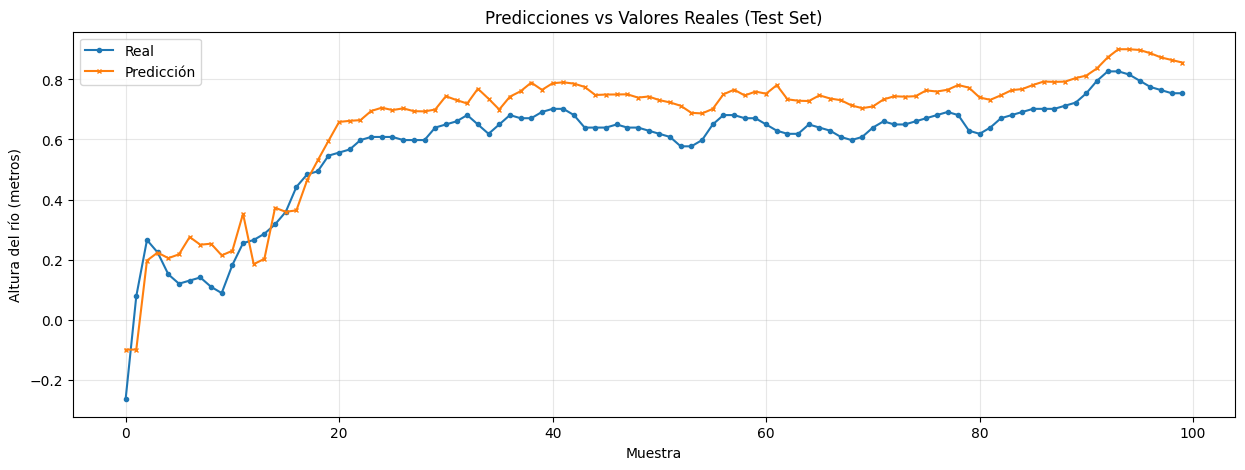

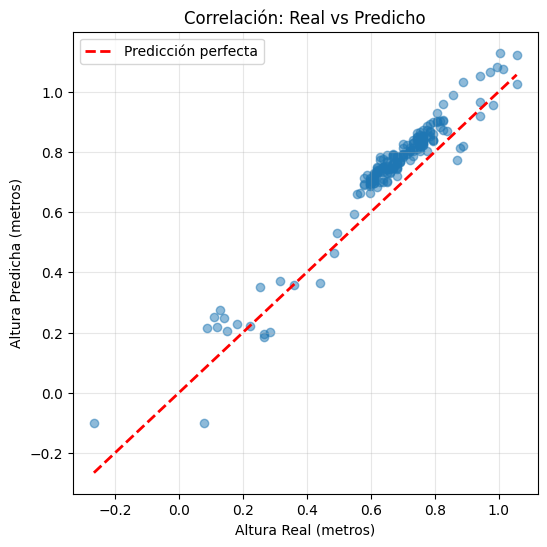

In [130]:
# Comparar predicciones vs valores reales
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# Mostrar solo las primeras 100 predicciones para que se vea claro
n_mostrar = 100

plt.plot(y_test_real[:n_mostrar], label='Real', marker='o', markersize=3)
plt.plot(y_pred[:n_mostrar], label='Predicción', marker='x', markersize=3)
plt.xlabel('Muestra')
plt.ylabel('Altura del río (metros)')
plt.title('Predicciones vs Valores Reales (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Scatter plot para ver correlación
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], 
        [y_test_real.min(), y_test_real.max()], 
        'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Altura Real (metros)')
plt.ylabel('Altura Predicha (metros)')
plt.title('Correlación: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [131]:
# Crear un DataFrame comparativo
import pandas as pd

comparacion = pd.DataFrame({
    'Altura_Real': y_test_real.flatten(),
    'Altura_Predicha': y_pred.flatten(),
    'Error_Absoluto': np.abs(y_test_real.flatten() - y_pred.flatten())
})

# Ver las primeras filas
print(comparacion.head(20))

# Estadísticas del error
print("\n--- Estadísticas del Error ---")
print(comparacion['Error_Absoluto'].describe())

# Ver los 10 peores errores
print("\n--- 10 Peores Predicciones ---")
peores = comparacion.nlargest(10, 'Error_Absoluto')
print(peores)

# Ver los 10 mejores predicciones
print("\n--- 10 Mejores Predicciones ---")
mejores = comparacion.nsmallest(10, 'Error_Absoluto')
print(mejores)

# Opcional: guardar a CSV
# comparacion.to_csv('predicciones_vs_reales.csv', index=False)

    Altura_Real  Altura_Predicha  Error_Absoluto
0       -0.2652        -0.100139        0.165061
1        0.0780        -0.099715        0.177715
2        0.2652         0.196721        0.068479
3        0.2236         0.223250        0.000350
4        0.1508         0.204603        0.053803
5        0.1196         0.217470        0.097870
6        0.1300         0.275055        0.145055
7        0.1404         0.249413        0.109013
8        0.1092         0.252860        0.143660
9        0.0884         0.213996        0.125596
10       0.1820         0.229256        0.047256
11       0.2548         0.352601        0.097801
12       0.2652         0.184718        0.080482
13       0.2860         0.202378        0.083622
14       0.3172         0.372610        0.055410
15       0.3588         0.359038        0.000238
16       0.4420         0.363861        0.078139
17       0.4836         0.464014        0.019586
18       0.4940         0.530519        0.036519
19       0.5460     

In [132]:
print(df["altura_value"].min())
print(df["altura_value"].max())
rango_total = 1.14 - (-0.13)
error_porcentual = (0.0567 / rango_total) * 100

print(f"Rango del río: {rango_total:.2f} metros")
print(f"Error promedio (MAE): {0.0567:.4f} metros")
print(f"Error relativo: {error_porcentual:.2f}%")

-0.13
1.14
Rango del río: 1.27 metros
Error promedio (MAE): 0.0567 metros
Error relativo: 4.46%


INICIANDO EXPERIMENTOS DE VENTANAS

PROBANDO VENTANA DE 1 DÍAS

  → Run 1/3
     MAE: 0.0668m | RMSE: 0.0767m | Error%: 5.26%

  → Run 2/3
     MAE: 0.0750m | RMSE: 0.0820m | Error%: 5.91%

  → Run 3/3
     MAE: 0.0775m | RMSE: 0.0847m | Error%: 6.10%

PROBANDO VENTANA DE 2 DÍAS

  → Run 1/3
     MAE: 0.0779m | RMSE: 0.0848m | Error%: 6.13%

  → Run 2/3
     MAE: 0.0768m | RMSE: 0.0825m | Error%: 6.04%

  → Run 3/3
     MAE: 0.0805m | RMSE: 0.0855m | Error%: 6.34%

PROBANDO VENTANA DE 4 DÍAS

  → Run 1/3
     MAE: 0.0701m | RMSE: 0.0758m | Error%: 5.52%

  → Run 2/3
     MAE: 0.0980m | RMSE: 0.1024m | Error%: 7.72%

  → Run 3/3
     MAE: 0.0751m | RMSE: 0.0804m | Error%: 5.92%

PROBANDO VENTANA DE 6 DÍAS

  → Run 1/3
     MAE: 0.0917m | RMSE: 0.0974m | Error%: 7.22%

  → Run 2/3
     MAE: 0.0635m | RMSE: 0.0712m | Error%: 5.00%

  → Run 3/3
     MAE: 0.0784m | RMSE: 0.0849m | Error%: 6.17%

RESUMEN DE RESULTADOS

Métricas por tamaño de ventana:
        mae_metros                       

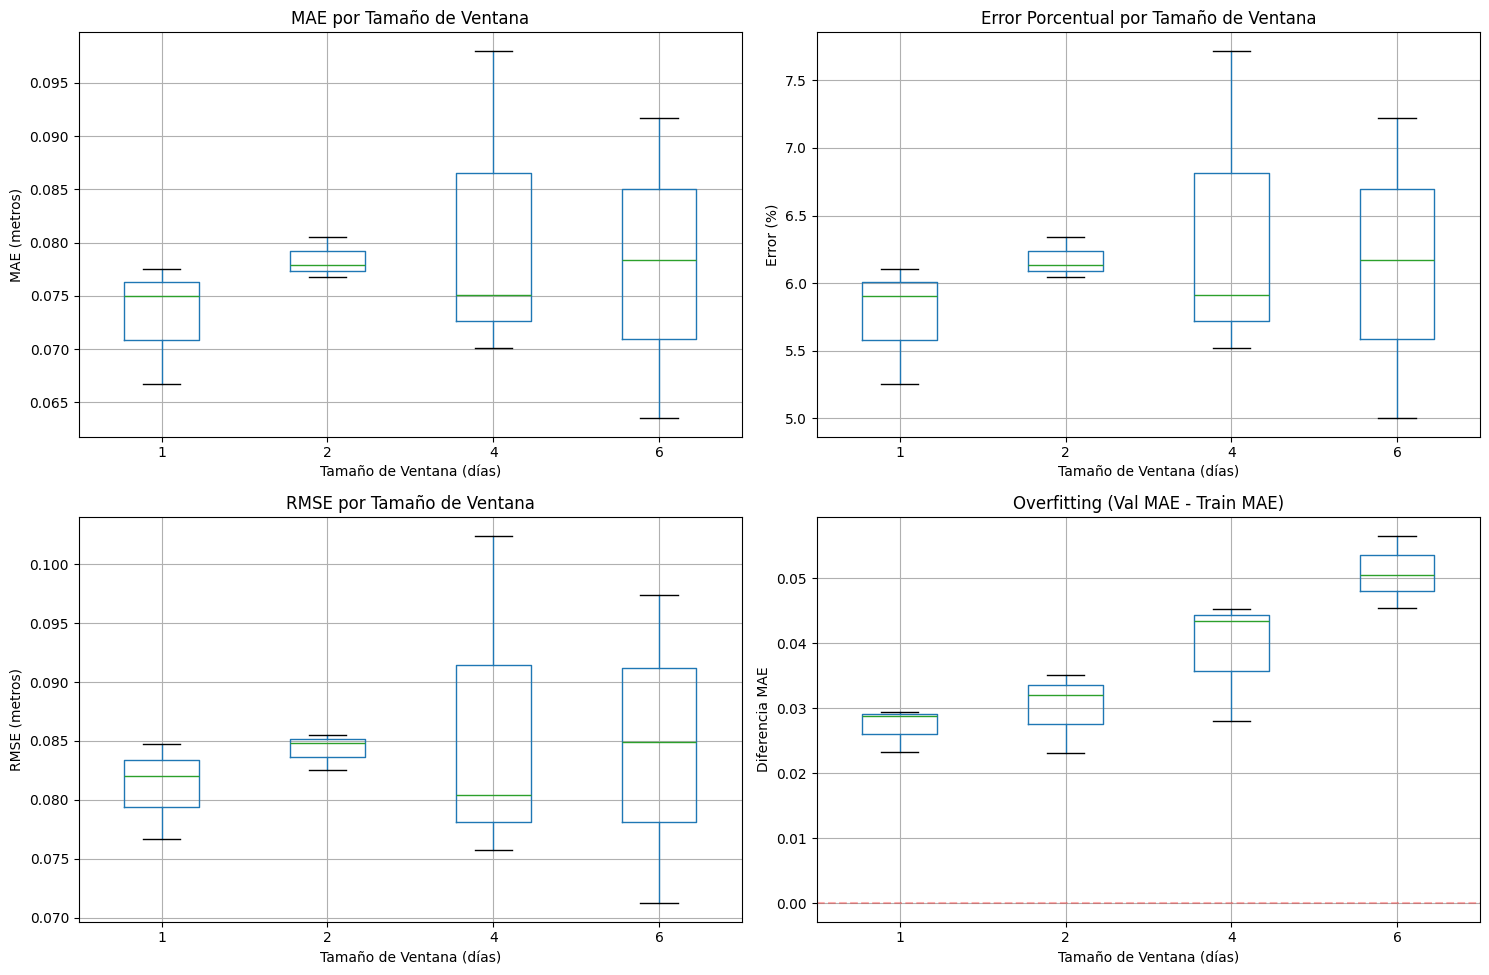


Resultados guardados en 'resultados_experimento_ventanas.csv'

TABLA RESUMEN DETALLADA

Ventana | MAE (m)        | RMSE (m)       | Error (%)      | Overfitting
--------------------------------------------------------------------------------
   1    | 0.0731±0.0056 | 0.0812±0.0041 | 5.76±0.44% | 0.0272
   2    | 0.0784±0.0019 | 0.0843±0.0016 | 6.17±0.15% | 0.0301
   4    | 0.0811±0.0149 | 0.0862±0.0142 | 6.38±1.17% | 0.0389
   6    | 0.0779±0.0141 | 0.0845±0.0131 | 6.13±1.11% | 0.0508


In [135]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fijar semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración del experimento
WINDOW_SIZES = [1, 2, 4, 6]  # Tamaños de ventana a probar
N_RUNS = 3  # Número de corridas por ventana
EPOCHS = 100
BATCH_SIZE = 32

# DataFrame para almacenar resultados
resultados_experimentos = []

# Función para crear modelo
def crear_modelo(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Bucle principal
print("=" * 80)
print("INICIANDO EXPERIMENTOS DE VENTANAS")
print("=" * 80)

for window_size in WINDOW_SIZES:
    print(f"\n{'=' * 80}")
    print(f"PROBANDO VENTANA DE {window_size} DÍAS")
    print(f"{'=' * 80}")
    
    # Crear ventanas con el tamaño actual
    X, y = crear_ventanas(df, features, window_size=window_size)
    
    # Split temporal
    split_idx = int(0.8 * len(X))
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    # Escalado
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Múltiples corridas
    for run in range(N_RUNS):
        print(f"\n  → Run {run + 1}/{N_RUNS}")
        
        # Fijar semilla diferente para cada run
        tf.random.set_seed(SEED + run)
        np.random.seed(SEED + run)
        
        # Crear y entrenar modelo
        model = crear_modelo(X_train_scaled.shape[1])
        
        history = model.fit(
            X_train_scaled, y_train_scaled,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            verbose=0
        )
        
        # Evaluar
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
        
        # Calcular métricas
        mae = mean_absolute_error(y_test_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
        
        # Calcular error porcentual
        rango_total = df["altura_value"].max() - df["altura_value"].min()
        error_porcentual = (mae / rango_total) * 100
        
        # Métricas de entrenamiento
        train_mae = history.history['mae'][-1]
        val_mae = history.history['val_mae'][-1]
        
        print(f"     MAE: {mae:.4f}m | RMSE: {rmse:.4f}m | Error%: {error_porcentual:.2f}%")
        
        # Guardar resultados
        resultados_experimentos.append({
            'ventana': window_size,
            'run': run + 1,
            'mae_metros': mae,
            'rmse_metros': rmse,
            'error_porcentual': error_porcentual,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'overfitting': val_mae - train_mae
        })

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_experimentos)

# Mostrar resumen por ventana
print("\n" + "=" * 80)
print("RESUMEN DE RESULTADOS")
print("=" * 80)

summary = df_resultados.groupby('ventana').agg({
    'mae_metros': ['mean', 'std', 'min', 'max'],
    'rmse_metros': ['mean', 'std'],
    'error_porcentual': ['mean', 'std'],
    'overfitting': ['mean']
}).round(4)

print("\nMétricas por tamaño de ventana:")
print(summary)

# Encontrar mejor configuración
mejor_ventana = df_resultados.groupby('ventana')['mae_metros'].mean().idxmin()
mejor_mae = df_resultados.groupby('ventana')['mae_metros'].mean().min()
std_mejor = df_resultados[df_resultados['ventana'] == mejor_ventana]['mae_metros'].std()

print(f"\n{'=' * 80}")
print(f"MEJOR CONFIGURACIÓN:")
print(f"  Ventana: {mejor_ventana} días")
print(f"  MAE promedio: {mejor_mae:.4f} ± {std_mejor:.4f} metros")
print(f"{'=' * 80}")

# Visualización comparativa
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. MAE por ventana (boxplot)
ax1 = axes[0, 0]
df_resultados.boxplot(column='mae_metros', by='ventana', ax=ax1)
ax1.set_title('MAE por Tamaño de Ventana')
ax1.set_xlabel('Tamaño de Ventana (días)')
ax1.set_ylabel('MAE (metros)')
ax1.get_figure().suptitle('')

# 2. Error porcentual por ventana
ax2 = axes[0, 1]
df_resultados.boxplot(column='error_porcentual', by='ventana', ax=ax2)
ax2.set_title('Error Porcentual por Tamaño de Ventana')
ax2.set_xlabel('Tamaño de Ventana (días)')
ax2.set_ylabel('Error (%)')
ax2.get_figure().suptitle('')

# 3. RMSE por ventana
ax3 = axes[1, 0]
df_resultados.boxplot(column='rmse_metros', by='ventana', ax=ax3)
ax3.set_title('RMSE por Tamaño de Ventana')
ax3.set_xlabel('Tamaño de Ventana (días)')
ax3.set_ylabel('RMSE (metros)')
ax3.get_figure().suptitle('')

# 4. Overfitting por ventana
ax4 = axes[1, 1]
df_resultados.boxplot(column='overfitting', by='ventana', ax=ax4)
ax4.set_title('Overfitting (Val MAE - Train MAE)')
ax4.set_xlabel('Tamaño de Ventana (días)')
ax4.set_ylabel('Diferencia MAE')
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

# Guardar resultados
df_resultados.to_csv('resultados_experimento_ventanas.csv', index=False)
print("\nResultados guardados en 'resultados_experimento_ventanas.csv'")

# Tabla resumen formateada
print("\n" + "=" * 80)
print("TABLA RESUMEN DETALLADA")
print("=" * 80)
print("\nVentana | MAE (m)        | RMSE (m)       | Error (%)      | Overfitting")
print("-" * 80)
for ventana in WINDOW_SIZES:
    datos = df_resultados[df_resultados['ventana'] == ventana]
    mae_mean = datos['mae_metros'].mean()
    mae_std = datos['mae_metros'].std()
    rmse_mean = datos['rmse_metros'].mean()
    rmse_std = datos['rmse_metros'].std()
    error_mean = datos['error_porcentual'].mean()
    error_std = datos['error_porcentual'].std()
    overfit = datos['overfitting'].mean()
    
    print(f"{ventana:^7} | {mae_mean:.4f}±{mae_std:.4f} | "
          f"{rmse_mean:.4f}±{rmse_std:.4f} | "
          f"{error_mean:.2f}±{error_std:.2f}% | {overfit:.4f}")

In [136]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("=" * 80)
print("PREDICCIONES ITERATIVAS - HORIZONTE 7 DÍAS")
print("=" * 80)

# Función para obtener la estación según la fecha
def obtener_estacion_fecha(fecha):
    mes = fecha.month
    dia = fecha.day
    
    if (mes == 12 and dia >= 21) or (mes <= 3 and (mes < 3 or dia <= 20)):
        return 0  # Verano
    elif (mes == 3 and dia >= 21) or (mes <= 6 and (mes < 6 or dia <= 20)):
        return 1  # Otoño
    elif (mes == 6 and dia >= 21) or (mes <= 9 and (mes < 9 or dia <= 20)):
        return 2  # Invierno
    else:
        return 3  # Primavera

# No podemos usar los últimos 7 registros como punto de partida
# porque no tienen datos futuros de precipitaciones
n_test_validos = len(X_test) - 7

print(f"\nTotal de datos en test: {len(X_test)}")
print(f"Datos válidos para predicción iterativa: {n_test_validos}")
print(f"(Descartamos últimos 7 porque no tienen precipitaciones futuras)\n")

# Arrays para almacenar todas las predicciones y valores reales
# Dimensiones: [n_muestras, 7 días]
predicciones_todos_horizontes = []
reales_todos_horizontes = []

# Para cada punto válido del test
for idx in range(n_test_validos):
    if (idx + 1) % 20 == 0:
        print(f"Procesando muestra {idx + 1}/{n_test_validos}...", end='\r')
    
    # Arrays para almacenar predicciones de esta muestra específica
    predicciones_muestra = []
    reales_muestra = []
    
    # Ventana inicial (últimos 7 días reales)
    ventana_actual = X_test_scaled[idx].copy()
    
    # Predecir los próximos 7 días
    for dia_futuro in range(1, 8):
        # Hacer predicción
        pred_scaled = model.predict(ventana_actual.reshape(1, -1), verbose=0)[0][0]
        pred_real = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        
        # Guardar predicción
        predicciones_muestra.append(pred_real)
        
        # Obtener el valor real de este día futuro
        idx_futuro = idx + dia_futuro
        valor_real = y_test[idx_futuro]
        reales_muestra.append(valor_real)
        
        # Preparar ventana para siguiente predicción
        if dia_futuro < 7:
            # Obtener precipitaciones reales del día futuro
            precip_futuro = df['precipitaciones_value'].iloc[split_idx + 7 + idx_futuro]
            
            # Obtener fecha del día futuro para calcular estación
            fecha_futuro = df['date'].iloc[split_idx + 7 + idx_futuro]
            estacion_futuro = obtener_estacion_fecha(fecha_futuro)
            
            # Crear nuevo punto con: predicción altura + precipitación real + estación
            nuevo_punto = np.array([pred_scaled, precip_futuro, estacion_futuro])
            
            # Escalar el nuevo punto (solo altura y precipitaciones, estación ya está escalada)
            # Necesitamos reescalar porque pred_scaled ya está escalado
            nuevo_punto_temp = np.array([[valor_real, precip_futuro, estacion_futuro]])
            nuevo_punto_escalado = scaler_X.transform(nuevo_punto_temp)[0]
            
            # Desplazar ventana: quitar primeros 3 valores (un día) y agregar nuevos 3
            ventana_actual = np.concatenate([ventana_actual[3:], nuevo_punto_escalado])
    
    predicciones_todos_horizontes.append(predicciones_muestra)
    reales_todos_horizontes.append(reales_muestra)

# Convertir a arrays numpy para facilitar cálculos
predicciones_todos_horizontes = np.array(predicciones_todos_horizontes)
reales_todos_horizontes = np.array(reales_todos_horizontes)

print("\n\n" + "=" * 80)
print("MÉTRICAS POR HORIZONTE TEMPORAL")
print("=" * 80)

# Calcular métricas para cada día
rango_total = df["altura_value"].max() - df["altura_value"].min()

print("\n{:<15} {:<12} {:<12} {:<12} {:<15}".format(
    "Horizonte", "MAE (m)", "RMSE (m)", "Error %", "Deterioro MAE"
))
print("-" * 80)

mae_dia_1 = None
for dia in range(7):
    preds_dia = predicciones_todos_horizontes[:, dia]
    reales_dia = reales_todos_horizontes[:, dia]
    
    mae = mean_absolute_error(reales_dia, preds_dia)
    rmse = np.sqrt(mean_squared_error(reales_dia, preds_dia))
    error_pct = (mae / rango_total) * 100
    
    if dia == 0:
        mae_dia_1 = mae
        deterioro = "-"
    else:
        deterioro = f"+{((mae / mae_dia_1 - 1) * 100):.1f}%"
    
    print(f"Día +{dia + 1:<8} {mae:.4f}      {rmse:.4f}      {error_pct:.2f}%      {deterioro}")

# Calcular promedio de todas las predicciones
print("\n" + "-" * 80)
mae_promedio = mean_absolute_error(reales_todos_horizontes.flatten(), 
                                    predicciones_todos_horizontes.flatten())
rmse_promedio = np.sqrt(mean_squared_error(reales_todos_horizontes.flatten(), 
                                             predicciones_todos_horizontes.flatten()))
error_pct_promedio = (mae_promedio / rango_total) * 100

print(f"{'PROMEDIO':<15} {mae_promedio:.4f}      {rmse_promedio:.4f}      {error_pct_promedio:.2f}%")

# Visualización de propagación del error
print("\n" + "=" * 80)
print("VISUALIZACIÓN DE PROPAGACIÓN DEL ERROR")
print("=" * 80)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. MAE por día
ax1 = axes[0, 0]
dias = range(1, 8)
maes = [mean_absolute_error(reales_todos_horizontes[:, i], 
                             predicciones_todos_horizontes[:, i]) 
        for i in range(7)]
ax1.plot(dias, maes, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Día de Predicción')
ax1.set_ylabel('MAE (metros)')
ax1.set_title('Propagación del Error MAE')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(dias)

# 2. RMSE por día
ax2 = axes[0, 1]
rmses = [np.sqrt(mean_squared_error(reales_todos_horizontes[:, i], 
                                     predicciones_todos_horizontes[:, i])) 
         for i in range(7)]
ax2.plot(dias, rmses, marker='s', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel('Día de Predicción')
ax2.set_ylabel('RMSE (metros)')
ax2.set_title('Propagación del Error RMSE')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(dias)

# 3. Error porcentual por día
ax3 = axes[1, 0]
errores_pct = [(mae / rango_total) * 100 for mae in maes]
ax3.plot(dias, errores_pct, marker='^', color='green', linewidth=2, markersize=8)
ax3.set_xlabel('Día de Predicción')
ax3.set_ylabel('Error (%)')
ax3.set_title('Error Porcentual por Horizonte')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(dias)

# 4. Ejemplo de predicciones vs reales para una muestra
ax4 = axes[1, 1]
muestra_ejemplo = 0  # Primera muestra del test
ax4.plot(dias, reales_todos_horizontes[muestra_ejemplo], 
         marker='o', label='Real', linewidth=2, markersize=8)
ax4.plot(dias, predicciones_todos_horizontes[muestra_ejemplo], 
         marker='x', label='Predicción', linewidth=2, markersize=8)
ax4.set_xlabel('Día de Predicción')
ax4.set_ylabel('Altura (metros)')
ax4.set_title(f'Ejemplo: Predicción vs Real (Muestra #{muestra_ejemplo + 1})')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(dias)

plt.tight_layout()
plt.show()

# Guardar resultados
resultados_df = pd.DataFrame({
    'Dia': range(1, 8),
    'MAE': maes,
    'RMSE': rmses,
    'Error_Porcentual': errores_pct,
    'Deterioro_vs_Dia1': [0] + [((m/maes[0] - 1) * 100) for m in maes[1:]]
})

resultados_df.to_csv('resultados_prediccion_iterativa.csv', index=False)
print(f"\nResultados guardados en 'resultados_prediccion_iterativa.csv'")

PREDICCIONES ITERATIVAS - HORIZONTE 7 DÍAS

Total de datos en test: 199
Datos válidos para predicción iterativa: 192
(Descartamos últimos 7 porque no tienen precipitaciones futuras)



ValueError: X has 3 features, but MinMaxScaler is expecting 18 features as input.

In [ ]:
#Tengo que seguir prompteandole a Claude para que entienda los inputs de mi modelo actual y mandarle el error.